In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download gauravpendharkar/blended-malware-image-dataset

Dataset URL: https://www.kaggle.com/datasets/gauravpendharkar/blended-malware-image-dataset
License(s): CC0-1.0
100% 2.69G/2.69G [00:33<00:00, 121MB/s]
100% 2.69G/2.69G [00:33<00:00, 86.4MB/s]


In [ ]:
!unzip /content/dataset.zip -d /content/dataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/dataset/malware_dataset/train/Stantinko/bf4f7ea7075ebf8e2f24a0fe89ff5dcac92a2647resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/bf5a31800a5172a02ab463736fb4d431eb48464fresized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/bf636f32e43e4b612ae0221e59c55fa83e672c89resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/bf8843ff50a03e882587481688d55e9c5576f918resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/bf9ea8c7fb840b53f8398d8c14b7906a5b336392resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/bfe1da086f34773cc5aee0982226ed9797fc6725resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/c005a8ba1ed7b520ef15193c77ef0abe74ab1829resized_image.png  
  inflating: /content/dataset/malware_dataset/train/Stantinko/c00bda

In [104]:
from __future__ import print_function
import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from skimage import exposure
import numpy as np
from imutils import paths
import cv2
import random
from sklearn.utils import Bunch
import argparse
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Modules used for data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")
# Modules used for random number choice
import random as r
# For graph visualization
import networkx as nx
from networkx.algorithms import bipartite

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Module for suppressing warnings.
import warnings
warnings.filterwarnings('ignore')

In [105]:
# Function to load and preprocess UCSB malware images
def load_ucsb_malware_images(datasetPath, min_images=20, image_size=(128, 100), equal_samples=True, test_size=0.33, seed=42, flatten=False):
    # Get all image paths in the dataset directory
    imagePaths = sorted(list(paths.list_images(datasetPath)))
    random.seed(seed)
    data, labels = [], []

    # Loop over the image paths to read and preprocess images
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(gray, image_size)
        if flatten:
            face = face.flatten()
        data.append(face)
        labels.append(imagePath.split(os.path.sep)[-2])

    data = np.array(data)
    labels = np.array(labels)

    # Optionally sample a balanced number of images per class
    if equal_samples:
        sampledIdxs = []
        for label in np.unique(labels):
            labelIdxs = np.where(labels == label)[0]
            if len(labelIdxs) >= min_images:
                labelIdxs = random.sample(list(labelIdxs), min_images)
                sampledIdxs.extend(labelIdxs)
        random.shuffle(sampledIdxs)
        data = data[sampledIdxs]
        labels = labels[sampledIdxs]

    # Shuffle and split the data into training and testing sets
    idxs = range(0, len(data))
    random.shuffle(list(idxs))
    split = int(len(idxs) * (1.0 - test_size))
    trainData, testData = data[:split], data[split:]
    trainLabels, testLabels = labels[:split], labels[split:]

    # Return the data as a Bunch object
    training = Bunch(name="training", data=trainData, target=trainLabels)
    testing = Bunch(name="testing", data=testData, target=testLabels)

    return training, testing, labels

In [106]:
class MalwareImages:

    # Initialize the dataset loader with the dataset path.
    def __init__(self, DATA_DIR : str, n : int):
        self.DATA_DIR = DATA_DIR
        self.class_distribution = dict()
        self.ROWS = n
        self.COLS = n

    # Computation of the class distribution of the dataset.
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))

    # Plotting the class distribution.
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution")
        plt.xlabel("Malware Class Frequency")
        plt.ylabel("Malware Type")

    # Insights into samples of different malware images across different classes.
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS,figsize=(15,15))

        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR,
                                           malware_type)
            malware_img_sample = r.choice(list(os.listdir(malware_img_dir)))
            malware_img_sample_path = os.path.join(malware_img_dir,
                                                   malware_img_sample)
            image = mpimg.imread(malware_img_sample_path)
            axs[c//self.COLS, c%self.COLS].imshow(image,
                                                  cmap = "gray")
            axs[c//self.COLS, c%self.COLS].set_title(malware_type)
            c += 1

        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()

In [107]:
malware_dir="/content/dataset/malware_dataset"

In [108]:
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution")
        plt.xlabel("Malware Class Frequency")
        plt.ylabel("Malware Type")

In [109]:
train_dataset = MalwareImages(os.path.join(malware_dir, "train"), 5)

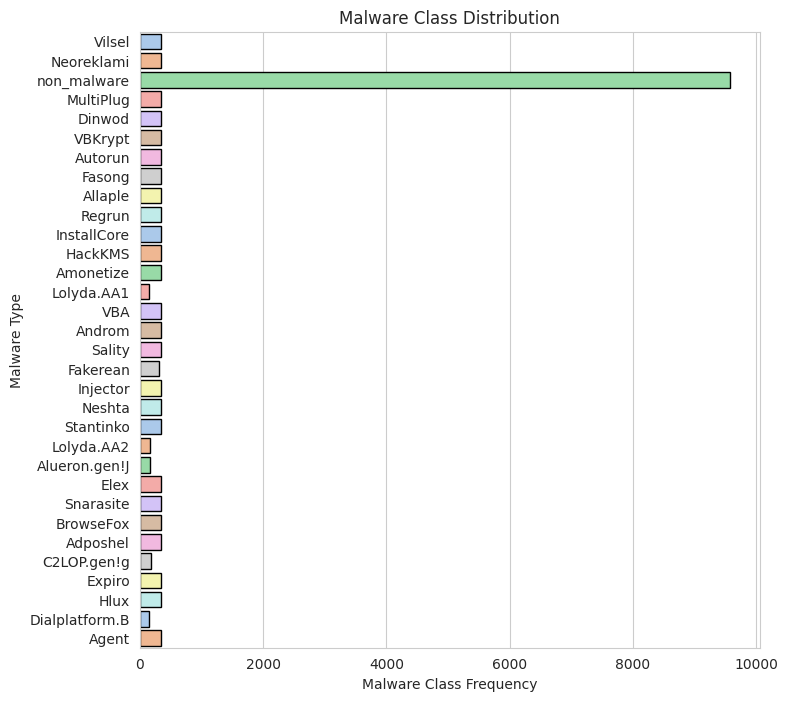

In [110]:
train_dataset.plot_class_distribution()

In [111]:
import os

def count_images_in_folder(folder_path):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.tif', '.webp'}
    files = os.listdir(folder_path)
    image_files = [f for f in files if os.path.isfile(os.path.join(folder_path, f)) and os.path.splitext(f)[1].lower() in image_extensions]
    return len(image_files)

def count_images_in_all_folders(base_folder_path):
    folder_image_counts = {}
    for root, dirs, files in os.walk(base_folder_path):
        num_images = count_images_in_folder(root)
        folder_image_counts[root] = num_images
    return folder_image_counts

def calculate_mean_excluding_non_malware(folder_image_counts, exclude_folder_name='non_malware'):
    total_images = 0
    folder_count = 0
    for folder, count in folder_image_counts.items():
        if exclude_folder_name not in folder:
            total_images += count
            folder_count += 1
    if folder_count == 0:
        return 0
    return total_images / folder_count

def assign_mean_to_non_malware(folder_image_counts, mean_value, target_folder_name='non_malware'):
    for folder in folder_image_counts.keys():
        if target_folder_name in folder:
            folder_image_counts[folder] = mean_value
    return folder_image_counts

def plot_class_distribution(folder_image_counts):
    folders = list(folder_image_counts.keys())
    counts = list(folder_image_counts.values())
    color_palette = sns.color_palette("pastel")
    plt.figure(figsize=(8,8))
    sns.barplot(y = folders,
                x = counts,
                palette = color_palette,
                edgecolor = "black",
                orient='h')
    plt.title("Malware Class Distribution")
    plt.xlabel("Malware Class Frequency")
    plt.ylabel("Malware Type")

# Example usage
base_folder_path = '/content/dataset/malware_dataset/train'  # Replace with your base folder path
folder_image_counts = count_images_in_all_folders(base_folder_path)

# Calculate the mean number of images excluding the "non_malware" folder
mean_images_excluding_non_malware = calculate_mean_excluding_non_malware(folder_image_counts)

# Assign the mean value to the "non_malware" folder
folder_image_counts = assign_mean_to_non_malware(folder_image_counts, mean_images_excluding_non_malware)



In [112]:
print(f'The mean number of images in the folders excluding "non_malware" is: {mean_images}')

The mean number of images in the folders excluding "non_malware" is: 308.375


In [113]:
for folder, count in folder_image_counts.items():
    print(f'The number of images in the folder "{folder}" is: {count}')

The number of images in the folder "/content/dataset/malware_dataset/train" is: 0
The number of images in the folder "/content/dataset/malware_dataset/train/Vilsel" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Neoreklami" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/non_malware" is: 308.375
The number of images in the folder "/content/dataset/malware_dataset/train/MultiPlug" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Dinwod" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/VBKrypt" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Autorun" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Fasong" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Allaple" is: 350
The number of images in the folder "/content/dataset/malware_dataset/train/Regru

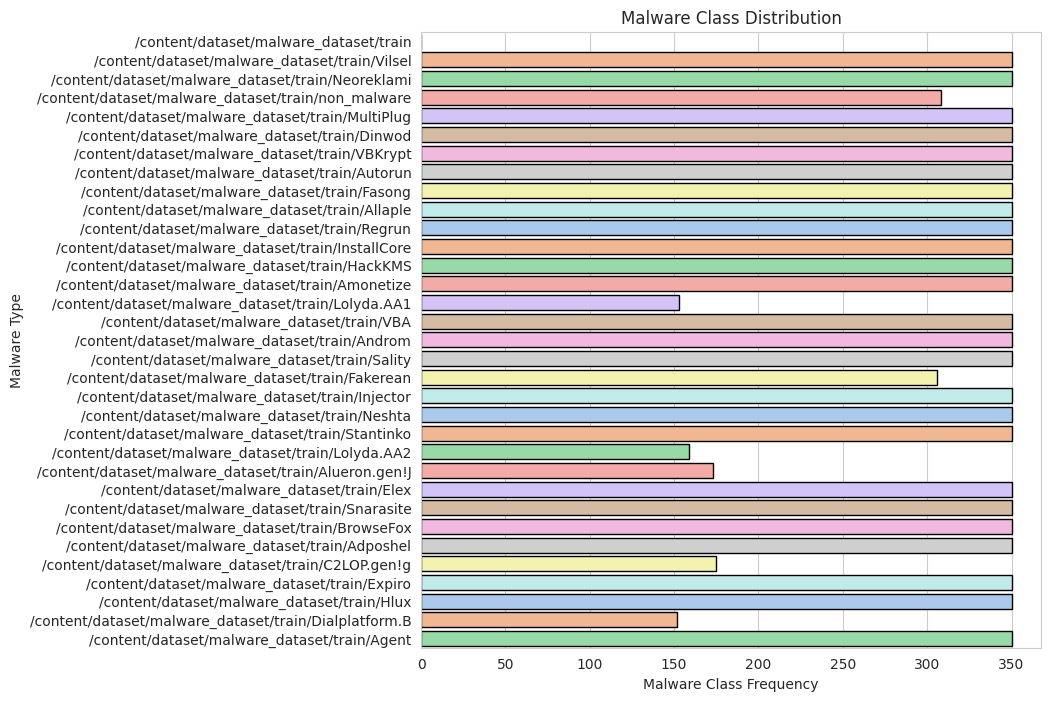

In [114]:
# Plot the updated distribution
plot_class_distribution(folder_image_counts)

In [115]:
# Class to create a montage of images for visualization
class ResultsMontage:
    def __init__(self, imageSize, imagesPerRow, numResults):
        self.imageW, self.imageH = imageSize
        self.imagesPerRow = imagesPerRow
        numCols = numResults // imagesPerRow
        self.montage = np.zeros((numCols * self.imageW, imagesPerRow * self.imageH, 3), dtype="uint8")
        self.counter, self.row, self.col = 0, 0, 0

    def addResult(self, image, text=None, highlight=False):
        if self.counter != 0 and self.counter % self.imagesPerRow == 0:
            self.col = 0
            self.row += 1
        image = cv2.resize(image, (self.imageH, self.imageW))
        startY, endY = self.row * self.imageW, (self.row + 1) * self.imageW
        startX, endX = self.col * self.imageH, (self.col + 1) * self.imageH
        self.montage[startY:endY, startX:endX] = image
        if text is not None:
            cv2.putText(self.montage, text, (startX + 10, startY + 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 3)
        if highlight:
            cv2.rectangle(self.montage, (startX + 3, startY + 3), (endX - 3, endY - 3), (0, 255, 0), 4)
        self.col += 1
        self.counter += 1

In [116]:
# Function to evaluate a trained model on the validation dataset
def evaluate_model(model, pca, datasetPath):
    training, testing, labels = load_ucsb_malware_images(datasetPath, flatten=True)
    valData, valLabels = testing.data, testing.target
    valData = pca.transform(valData)
    predictions = model.predict(valData)
    print("[INFO] evaluating model on validation data...")
    print(classification_report(valLabels, predictions))
    print("Accuracy:", accuracy_score(valLabels, predictions))


In [117]:
# Main function to load data, train the model, and evaluate it
def main(n_comp, min_imgs, whiten, visualize):
    print('No of PCs:', n_comp)
    print('No of min_images:', min_imgs)
    print("[INFO] loading UCSB malware image dataset...")
    training, testing, labels = load_ucsb_malware_images('/content/dataset/malware_dataset/train', min_images=min_imgs, flatten=True, test_size=0.25)
    print("[INFO] creating eigenvectors for the malware images...")

    # Apply PCA to reduce the dimensionality of the data
    pca = PCA(svd_solver="randomized", n_components=n_comp, whiten=whiten)
    trainData = pca.fit_transform(training.data)

    # Optionally visualize the eigenvectors
    if visualize:
        montage = ResultsMontage((100, 128), 4, 16)
        for i, component in enumerate(pca.components_[:16]):
            component = component.reshape((100, 128))
            component = exposure.rescale_intensity(component, out_range=(0, 255)).astype("uint8")
            component = np.dstack([component] * 3)
            montage.addResult(component)
        mean = pca.mean_.reshape((100, 128))
        mean = exposure.rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
        cv2.imshow("Mean Malware Image", mean)
        cv2.imshow("Eigen Malware", montage.montage)
        cv2.waitKey(0)

    print("[INFO] training classifier...")
    # Create a Random Forest classifier
    model = RandomForestClassifier(random_state=84)

    # Define the parameter grid for GridSearchCV to find the best hyperparameters
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['sqrt', 'log2'],  # Removed 'auto' as it is deprecated
        'max_depth': [10, 20, 30],
        'criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(trainData, training.target)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Fit the best model found by grid search on the training data
    best_model = grid_search.best_estimator_
    print("[INFO] fitting best model with training data...")
    best_model.fit(trainData, training.target)
    # Evaluate the model on the testing data
    predictions = best_model.predict(pca.transform(testing.data))
    print("[INFO] evaluating model...")
    print(classification_report(testing.target, predictions))
    print("Accuracy:", accuracy_score(testing.target, predictions))



In [118]:


# Entry point for the script
if __name__ == "__main__":
    if 'ipykernel' in sys.modules:
        # If running in a Jupyter notebook or IPython environment, use default parameters
        n_comp = 100
        min_imgs = 50
        whiten = True
        visualize = False
    else:
        # If running as a script, parse command line arguments
        parser = argparse.ArgumentParser()
        parser.add_argument('-nc', '--n_comp', default=100, type=int)
        parser.add_argument('-min_im', '--min_images', default=50, type=int)
        parser.add_argument('-wh_c', '--whiten_check', default=1, type=int)
        parser.add_argument('-vis_c', '--visualize_check', default=0, type=int)
        args = parser.parse_args()
        n_comp = args.n_comp
        min_imgs = args.min_images
        whiten = args.whiten_check == 1
        visualize = args.visualize_check == 1
    main(n_comp, min_imgs, whiten, visualize)

No of PCs: 100
No of min_images: 50
[INFO] loading UCSB malware image dataset...
[INFO] creating eigenvectors for the malware images...
[INFO] training classifier...
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score: 0.8391666666666667
[INFO] fitting best model with training data...
[INFO] evaluating model...
                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00         6
         Agent       0.89      0.50      0.64        16
       Allaple       0.78      0.70      0.74        10
 Alueron.gen!J       0.90      1.00      0.95        18
     Amonetize       1.00      0.78      0.88         9
        Androm       0.81      0.76      0.79        17
       Autorun       1.00      0.71      0.83        14
     BrowseFox       0.75      0.75      0.75        12
   C2LOP.gen!g       0.35      0.86      0.50         7
Dialplatform.B       1.00      1.00      1.00        13
       